In [1]:
from servicex import ServiceXDataset

from servicex_coffea import DataSource
from servicex_coffea import FuncAdlDataset
from servicex_coffea import Analysis
from servicex_coffea import Accumulator
from servicex_coffea import LocalExecutor

import matplotlib.pyplot as plt

from coffea import hist, processor


In [2]:
dids = ['mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00']
datasets = [
    ServiceXDataset(did, backend_type='xaod', ignore_cache=False)
    for did in dids
]

In [5]:
leptons_per_event_query = FuncAdlDataset() \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: (ls.Select(lambda e: e.pt()/1000.0), ls.Select(lambda e: e.eta()), ls.Select(lambda e: e.phi()), ls.Select(lambda e: e.m()/1000.0), ls.Select(lambda e: e.charge()))) \
        .AsROOTTTree('data.root', 'mytree', ('electrons_pt', 'electrons_eta', 'electrons_phi', 'electrons_mass', 'electrons_charge'))

In [6]:
datasource = DataSource(query=leptons_per_event_query, metadata={}, datasets=datasets)

In [7]:
class Z_EEAnalysis(Analysis):
    def __init__(self):
        self.accumulator = Accumulator({
            "mass": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
            ),
        })

    @staticmethod
    def process(output, events):
        import awkward as ak

        dataset = events.metadata['dataset']
        electrons = events.electrons

        # Form the invar mass, plot.
        cut = (ak.num(electrons) == 2)
        diele = electrons[cut][:, 0] + electrons[cut][:, 1]

        output["sumw"][dataset] += len(events)
        output["mass"].fill(
            dataset=dataset,
            mass=diele.mass,
        )

        return output




In [8]:
analysis = Z_EEAnalysis()
executor = LocalExecutor()

Using matplotlib backend: MacOSX


mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r62…

        Downloaded:   0%|          | 0/9000000000.0 [00:00]

Dataset  <servicex.servicex.StreamInfoPath object at 0x135c3cd90>
---- file:///Users/bengal1/dev/IRIS-HEP/Servicex_Coffea/notebooks/cache/data/228d2e6f-fe15-4b91-b1a7-895ac16a3fc0/root___fax.mwt2.org_1094__pnfs_uchicago.edu_atlaslocalgroupdisk_rucio_mc15_13TeV_04_1b_DAOD_STDM3.05630052._000015.pool.root.1
Dataset  <servicex.servicex.StreamInfoPath object at 0x135cb7a10>
---- file:///Users/bengal1/dev/IRIS-HEP/Servicex_Coffea/notebooks/cache/data/228d2e6f-fe15-4b91-b1a7-895ac16a3fc0/root___fax.mwt2.org_1094__pnfs_uchicago.edu_atlaslocalgroupdisk_rucio_mc15_13TeV_18_14_DAOD_STDM3.05630052._000013.pool.root.1
{'mass': <Hist (dataset,mass) instance at 0x135b24790>, 'sumw': defaultdict_accumulator(<class 'float'>, {'mc15x': 50000.0})}


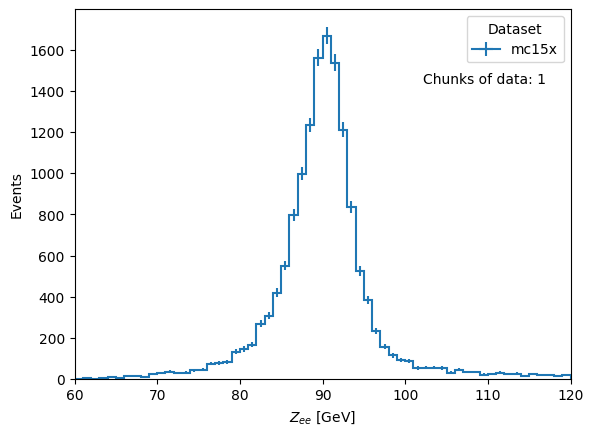

In [ ]:
%matplotlib 
async def plot_stream(accumulator_stream):
  global first
  fig, axes = plt.subplots()
  first = True


  count = 0
  async for coffea_info in accumulator_stream:
    print(coffea_info)
    hist.plot1d(coffea_info['mass'], ax=axes)

    count += 1
    plt.text(0.95, 0.8, f'Chunks of data: {count}', horizontalalignment='right', transform=axes.transAxes)

    # Either display it or update a previous version of the plot
    if first:
        display(fig, display_id='mass_update')
        first = False
    else:
        update_display(fig, display_id='mass_update')
  return coffea_info

await plot_stream(executor.execute(analysis, datasource))
# plt.close()  # Prevents another copy of the plot showing up in the notebook